In [1]:
import numpy as np
import matplotlib.pyplot as plt

from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains
from pymoo.decomposition.asf import ASF
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import add_auxilary_points_to_trajectory, convert_x_y_to_6d_traj_xz, get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability, MeanHeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ManipulabilityReward, ForceEllipsoidReward, ZRRReward, MinForceReward, MinManipulabilityReward,DexterityIndexReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward, EndPointIMFReward,ActuatedMassReward, TrajectoryIMFReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT
from auto_robot_design.generator.topologies.graph_manager_2l import GraphManager2L
from auto_robot_design.optimization.saver import (
    load_checkpoint,
)
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory
from auto_robot_design.generator.topologies.bounds_preset import get_preset_by_index_with_bounds
import pinocchio as pin

pin.seed(2)

Resulting directory path: D:/work/projects/mechanism_builder/apps/experiments/all_topologies_acc_hl_six_trajectories/results/first_setup/all_topologies_100gen_64pop/topology_0_2024-10-31_23-40-42


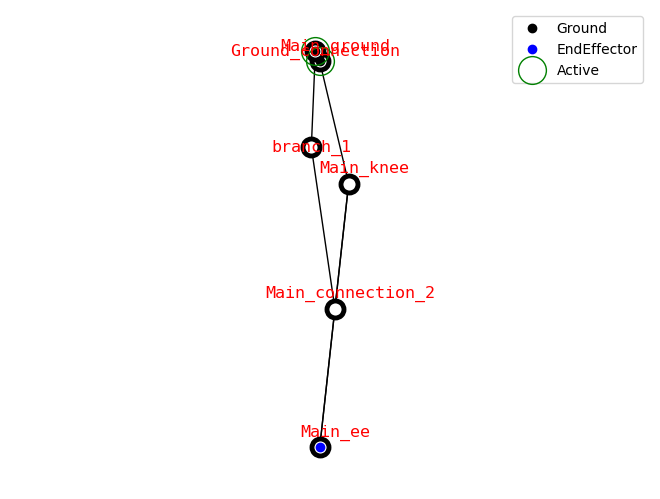

In [2]:
import tkinter as tk
from tkinter import filedialog

def select_directory():
    # Create a root window
    root = tk.Tk()
    # Hide the root window
    root.withdraw()
    # Make the root window the topmost window
    root.call('wm', 'attributes', '.', '-topmost', True)
    # Open directory dialog and store the selected directory path
    directory_path = filedialog.askdirectory(initialdir="./",
        title="Select a directory"
    )
    root.update_idletasks() 
    root.destroy()
    # Check if a directory was selected
    if directory_path:
        #print(f"Selected directory: {directory_path}")
        return directory_path
    else:
        #print("No directory selected")
        return None

# Call the function to open the directory dialog
selected_directory = select_directory()
print(f"Resulting directory path: {selected_directory}")


problem = MultiCriteriaProblem.load(
    selected_directory
)

checkpoint = load_checkpoint(selected_directory)
optimizer = PymooOptimizer(problem, checkpoint)
optimizer.load_history(selected_directory)
res = optimizer.run()

F = res.F
fl = F.min(axis=0)
fu = F.max(axis=0)

approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
weights = np.array([0.5, 0.5])

decomp = ASF()
b = decomp.do(nF, 1/weights).argmin()
best_x = res.X[b]

graph = problem.graph_manager.get_graph(best_x)
draw_joint_point(graph)

In [3]:
thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                              density={"default": density, "G": body_density},
                              thickness={"default": thickness, "EE": 0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(
                                  MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
                              )

In [16]:
histF = res.F
validF1 = histF[:,0][histF[:,0]<0]
validF2 = histF[:,1][histF[:,1]<0]
print('Percentage of valid mechanisms:', len(validF1)/len(histF))

Percentage of valid mechanisms: 1.0


In [5]:
gm = problem.graph_manager
gm.mutation_ranges

{'Ground_connection_0': (-0.2, 0.0),
 'Ground_connection_2': (-0.028999999999999998, 0.07100000000000001),
 'Main_knee_2': (-0.30000000000000004, -0.1),
 'Main_connection_2_0': (-0.2, 0.2),
 'Main_connection_2_2': (-0.3, 0.6),
 'branch_1_0': (-0.05, 0.1),
 'branch_1_2': (-0.3, -0.1)}

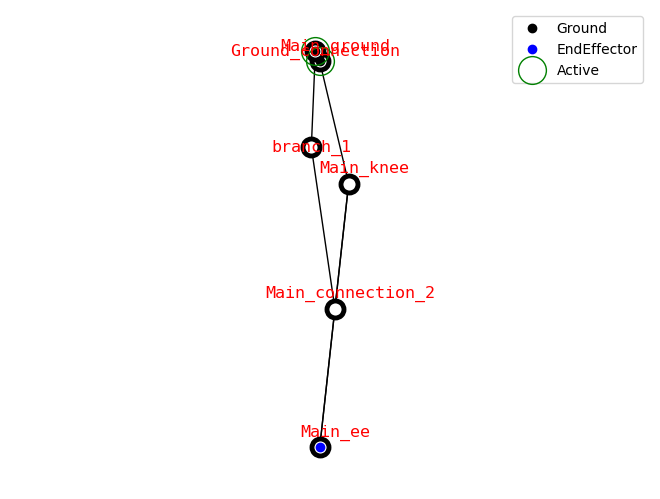

In [6]:
draw_joint_point(graph)

In [10]:
reward_class = list(problem.rewards_and_trajectories.rewards.items())[0][1][0]

trajectory = ground_symmetric_step1
range_idx = 3
range = gm.mutation_ranges[list(gm.mutation_ranges.keys())[range_idx]]
print(range)
values = np.linspace(range[0],range[1],num=30,endpoint=True)
x = best_x.copy()
reward_values = []
valid_points=[]

for value in values:
    x[range_idx] = value
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    
    constrain_error, results = problem.soft_constrain.calculate_constrain_error(crag, fixed_robot, free_robot)
    constrain_error
    if constrain_error == 0:
        print(value)
        reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
        reward_values.append(reward)
        valid_points.append(value)
        
    else:
        print(value, constrain_error)

plt.scatter(valid_points, reward_values)


(-0.2, 0.2)
-0.2


AttributeError: 'tuple' object has no attribute 'calculate'

In [21]:
from pinocchio.visualize import MeshcatVisualizer
import meshcat
counter = 0
suspicious_points = []
for value in values:
    x[range_idx] = value
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    
    constrain_error, results = soft_constrain.calculate_constrain_error(crag, fixed_robot, free_robot)
    constrain_error
    if constrain_error == 0:
        counter+=1
        if counter==1 or counter==2:
            # viz = MeshcatVisualizer(fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model)
            # viz.viewer = meshcat.Visualizer().open()
            # viz.clean()
            # viz.loadViewerModel()
            # draw_joint_point(graph)
            # plt.show()
            suspicious_points.append(value)
            point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
        print(value)
        reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
        reward_values.append(reward)
        valid_points.append(value)
        
    else:
        print(value, constrain_error)

-0.2
-0.18620689655172415
-0.1724137931034483
-0.15862068965517243
-0.14482758620689656
-0.13103448275862067
-0.11724137931034483
-0.10344827586206896
-0.0896551724137931
-0.07586206896551724
-0.062068965517241365
-0.0482758620689655
-0.03448275862068964
-0.02068965517241378
-0.006896551724137917
0.006896551724137945
0.020689655172413807
0.03448275862068967
0.04827586206896553
0.06206896551724139
0.07586206896551728
0.08965517241379312
0.103448275862069
0.11724137931034484
0.13103448275862073
0.14482758620689656
0.15862068965517245
0.1724137931034483
0.18620689655172418
0.2


In [22]:
x[range_idx] = suspicious_points[1]
graph = gm.get_graph(x)
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
viz = MeshcatVisualizer(fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model)
viz.viewer = meshcat.Visualizer().open()
viz.clean()
viz.loadViewerModel()
point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory, viz=viz)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/
